# Analyzing the results for `sciplex_hparam`

This is preliminary to the `fintuning_num_genes` and `finetuning_OOD_prediction` experiments. We look at the results of sweeping the optimisation related hyperparameters for fine-tuning on the sciplex dataset for all other embeddings.

In [6]:
import math
from pathlib import Path

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import seml
from matplotlib import pyplot as plt

matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_context("poster")
pd.set_option('display.max_columns', 100)

In [2]:
results = seml.get_results(
    "sciplex_hparam",
    to_data_frame=True,
    fields=["config", "result", "seml", "config_hash"],
    states=["COMPLETED"],
)

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

/home/icb/leon.hetzel/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


In [32]:
# Look at number of experiments per model
results["config.model.embedding.model"].value_counts()

rdkit          20
jtvae          20
MPNN           20
vanilla        20
grover_base    17
seq2seq        14
Name: config.model.embedding.model, dtype: int64

In [33]:
results.loc[:, [c for c in results.columns if 'disentanglement' in c]]

,result.perturbation disentanglement,result.covariate disentanglement
0,[0.02395700290799141],[[0.7632986903190613]]
1,[0.023617437109351158],[[0.9189021587371826]]
2,[0.024413662031292915],[[0.7295176982879639]]
3,[0.02581876516342163],[[0.8676275610923767]]
4,[0.02321932464838028],[[0.6091355085372925]]
...,...,...
106,[0.02813718467950821],[[0.9940516948699951]]
107,[0.027727363631129265],[[0.9928925037384033]]
108,[0.023394962772727013],[[0.5803191661834717]]
109,[0.025807056576013565],[[0.7139678597450256]]


## Preprocessing the results dataframe

In [34]:
sweeped_params = [
    # "model.hparams.dim",
    # "model.hparams.dropout",
    # "model.hparams.dosers_width",
    # "model.hparams.dosers_depth",
    "model.hparams.dosers_lr",
    "model.hparams.dosers_wd",
    # "model.hparams.autoencoder_width",
    # "model.hparams.autoencoder_depth",
    "model.hparams.autoencoder_lr",
    "model.hparams.autoencoder_wd",
    "model.hparams.adversary_width",
    "model.hparams.adversary_depth",
    "model.hparams.adversary_lr",
    "model.hparams.adversary_wd",
    "model.hparams.adversary_steps",
    "model.hparams.reg_adversary",
    "model.hparams.penalty_adversary",
    "model.hparams.batch_size",
    "model.hparams.step_size_lr",
    # "model.hparams.embedding_encoder_width",
    # "model.hparams.embedding_encoder_depth",
]

In [35]:
# percentage of training runs that resulted in NaNs or totally failed
nan_results = results[results["result.loss_reconstruction"].apply(lambda x: math.isnan(sum(x)))]
results_clean = results[~results["result.loss_reconstruction"].apply(lambda x: math.isnan(sum(x)))].copy()
print(len(nan_results) / len(results))

# Remove runs with r2 < 0.6 on the training set
results_clean = results_clean[results_clean['result.training'].apply(lambda x: x[0][0])>0.6]

0.0


In [36]:
results_clean["config.model.embedding.model"].value_counts()

jtvae          20
rdkit          17
MPNN           17
vanilla        16
grover_base    15
seq2seq        13
Name: config.model.embedding.model, dtype: int64

In [37]:
# calculate some stats
get_mean = lambda x: np.array(x)[-1, 0]
get_mean_de = lambda x: np.array(x)[-1, 1]

results_clean["result.training_mean"] = results_clean["result.training"].apply(get_mean)
results_clean["result.training_mean_de"] = results_clean["result.training"].apply(get_mean_de)
results_clean["result.val_mean"] = results_clean["result.test"].apply(get_mean)
results_clean["result.val_mean_de"] = results_clean["result.test"].apply(get_mean_de)
results_clean["result.test_mean"] = results_clean["result.ood"].apply(get_mean)
results_clean["result.test_mean_de"] = results_clean["result.ood"].apply(get_mean_de)
results_clean["result.perturbation disentanglement"] = results_clean["result.perturbation disentanglement"].apply(lambda x: x[0])


results_clean.head(3)

,_id,config_hash,seml.executable,seml.name,seml.output_dir,seml.conda_environment,seml.working_dir,seml.source_files,seml.output_file,seml.command,seml.temp_dir,config.overwrite,config.db_collection,config.dataset.data_params.covariate_keys,config.dataset.data_params.dataset_path,config.dataset.data_params.degs_key,config.dataset.data_params.dose_key,config.dataset.data_params.pert_category,config.dataset.data_params.perturbation_key,config.dataset.data_params.smiles_key,config.dataset.data_params.split_key,config.dataset.data_params.use_drugs_idx,config.dataset.dataset_type,config.model.additional_params.decoder_activation,config.model.additional_params.doser_type,config.model.additional_params.patience,config.model.additional_params.seed,config.model.embedding.directory,config.model.embedding.model,config.model.hparams.adversary_depth,config.model.hparams.adversary_lr,config.model.hparams.adversary_steps,config.model.hparams.adversary_wd,config.model.hparams.adversary_width,config.model.hparams.autoencoder_depth,config.model.hparams.autoencoder_lr,config.model.hparams.autoencoder_wd,config.model.hparams.autoencoder_width,config.model.hparams.batch_size,config.model.hparams.dim,config.model.hparams.dosers_depth,config.model.hparams.dosers_lr,config.model.hparams.dosers_wd,config.model.hparams.dosers_width,config.model.hparams.dropout,config.model.hparams.embedding_encoder_depth,config.model.hparams.embedding_encoder_width,config.model.hparams.penalty_adversary,config.model.hparams.reg_adversary,config.model.hparams.step_size_lr,config.model.load_pretrained,config.model.pretrained_model_hashes.GCN,config.model.pretrained_model_hashes.MPNN,config.model.pretrained_model_hashes.grover_base,config.model.pretrained_model_hashes.jtvae,config.model.pretrained_model_hashes.rdkit,config.model.pretrained_model_hashes.seq2seq,config.model.pretrained_model_hashes.vanilla,config.model.pretrained_model_hashes.weave,config.model.pretrained_model_path,config.profiling.outdir,config.profiling.run_profiler,config.training.checkpoint_freq,config.training.full_eval_during_train,config.training.max_minutes,config.training.num_epochs,config.training.run_eval_disentangle,config.training.save_checkpoints,config.training.save_dir,config.seed,result.epoch,result.stats_epoch,result.loss_reconstruction,result.loss_adv_drugs,result.loss_adv_covariates,result.penalty_adv_drugs,result.penalty_adv_covariates,result.elapsed_time_min,result.training,result.test,result.ood,result.perturbation disentanglement,result.optimal for perturbations,result.covariate disentanglement,result.optimal for covariates,result.total_epochs,result.training_mean,result.training_mean_de,result.val_mean,result.val_mean_de,result.test_mean,result.test_mean_de
0,1,4a9fb39bf40129dde628a487b0b56543,compert/seml_sweep_icb.py,ft_sciplex_hparam,/mnt/home/icb/leon.hetzel/git/CPA_graphs/sweep...,chemical_CPA,/mnt/home/icb/leon.hetzel/git/CPA_graphs,"[[compert/seml_sweep_icb.py, 61f0039e497dd9b7c...",/mnt/home/icb/leon.hetzel/git/CPA_graphs/sweep...,python compert/seml_sweep_icb.py with 'model={...,/tmp/780ffe89-04aa-4714-a620-203e36a7807f,1,sciplex_hparam,cell_type,/storage/groups/ml01/projects/2021_chemicalCPA...,lincs_DEGs,dose,cov_drug_dose_name,condition,SMILES,split_ho_pathway,True,trapnell,linear,amortized,4,1337,None,rdkit,2,0.000364,3,7.459343e-07,128,4,0.000561,1.329292e-07,256,64,32,3,0.000561,1.329292e-07,64,0.262378,4,128,2.368864,15.355287,50,True,aedb25c686fb856e574a951f749b8dcf,ff9629a1b216372be8b205556cabc6fb,ff420aea264fca7668ecb147f60762a1,a7060ac4e2c6154e64a13acd414cbba2,4f061dbfc7af05cf84f06a724b0c8563,e31119adc782888d5b75c57f8c803ee0,ba3569d1f5898a6bb964b7fafbed2641,1244d8b476696a7e1c01fd05d73d7450,/storage/groups/ml01/projects/2021_chemicalCPA...,./,False,15,False,1200,1500,True,True,/storage/groups/ml01/projects/2021_chemicalCPA...,954844182,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[195],"[1336.0160297362454, -9812.380385041237, -1035...","[39476.32917785644

## Look at early stopping

Text(0.5, 1.0, 'Total epochs before final stopping (min 125)')

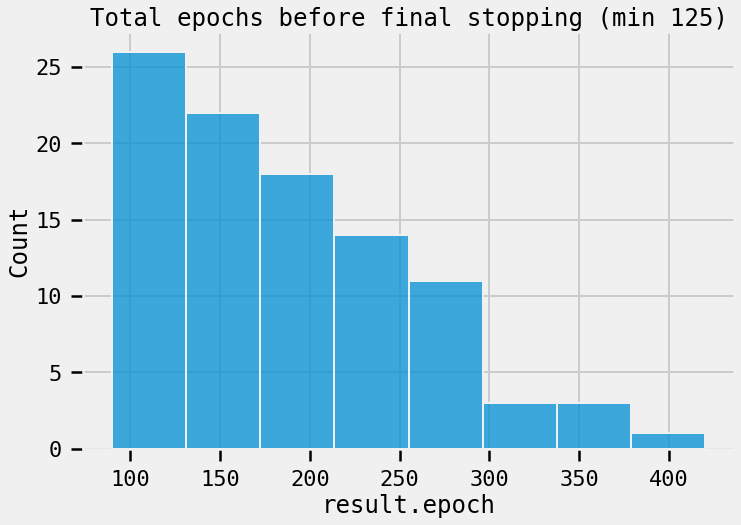

In [38]:
ax = sns.histplot(data=results_clean["result.epoch"].apply(max))
ax.set_title("Total epochs before final stopping (min 125)")

## Look at $r^2$ reconstruction

In [39]:
[c for c in results_clean.columns if 'pretrain' in c]

results_clean[["config.model.embedding.model", 'config.model.load_pretrained']]

,config.model.embedding.model,config.model.load_pretrained
0,rdkit,True
2,rdkit,True
3,rdkit,True
4,rdkit,True
5,rdkit,True
...,...,...
106,vanilla,False
107,vanilla,False
108,vanilla,False
109,vanilla,False


### DE genes

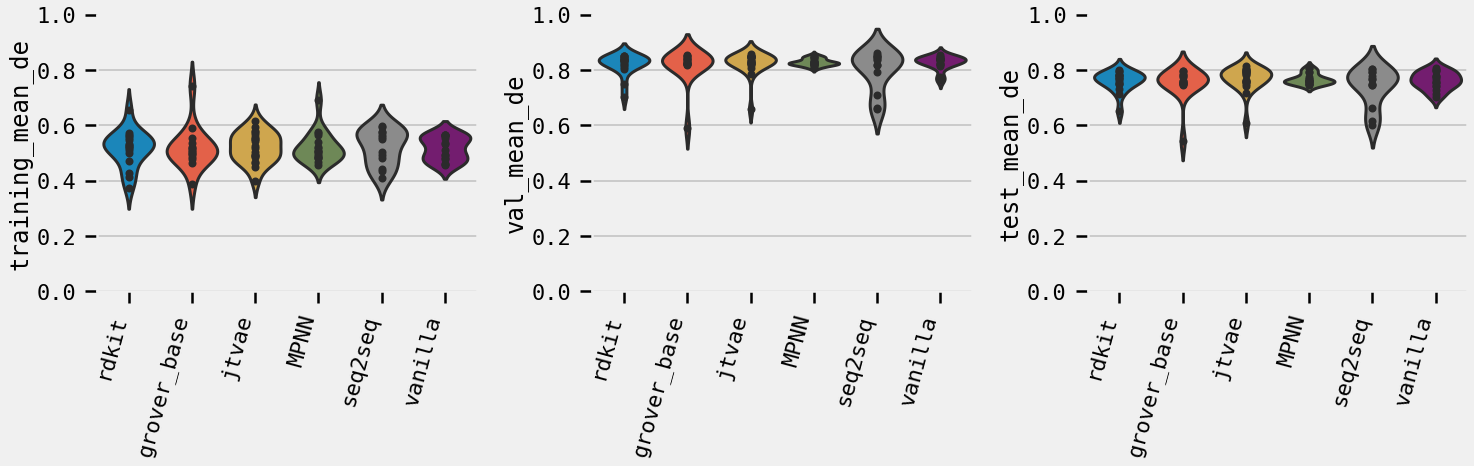

In [40]:
rows = 1 
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(7*cols, 7*rows), sharex=True)

for i, y in enumerate(("result.training_mean_de", "result.val_mean_de", "result.test_mean_de")):
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y, inner='point' ,ax=ax[i], scale='width')
    ax[i].set_ylim([0.0,1])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha="right")
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    plt.tight_layout()

### All genes

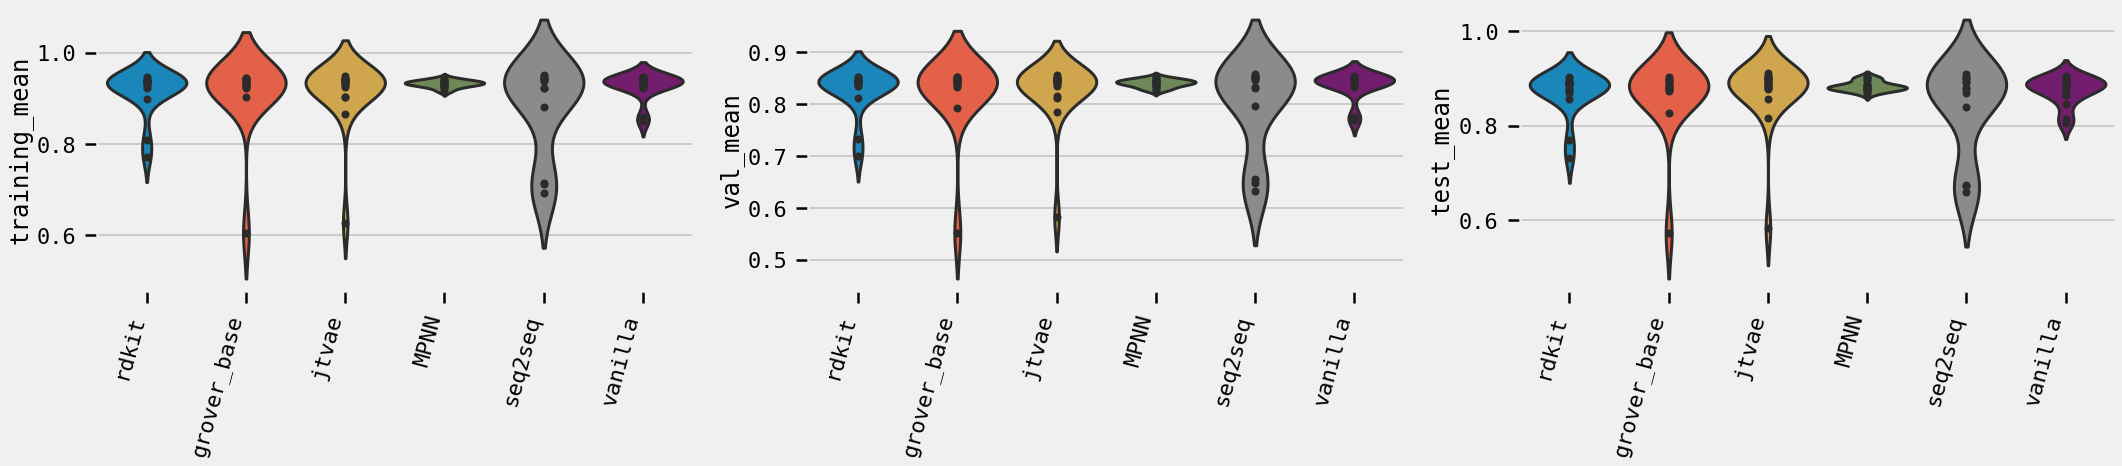

In [41]:
rows = 1 
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols, 7*rows), sharex=True)

for i, y in enumerate(("result.training_mean", "result.val_mean", "result.test_mean")):
    # sns.violinplot(data=results_clean[results_clean['config.model.load_pretrained']==True], x="config.model.embedding.model", y=y, inner='point' ,ax=ax[i], scale='width')
    sns.violinplot(
        data=results_clean,
        x="config.model.embedding.model", 
        y=y, 
        # hue='config.model.load_pretrained',
        inner='point',
        ax=ax[i], 
        scale='width')
    # ax[i].set_ylim([0.82,1])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    plt.tight_layout()

## Look at disentanglement scores

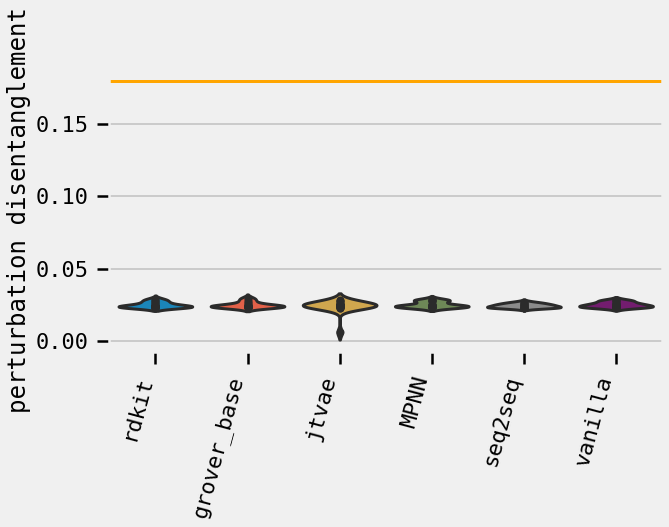

In [42]:
rows = 1 
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(10*cols, 7*rows), sharex=True)

for y in ["result.perturbation disentanglement"]:
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y, inner='point' ,ax=ax, scale='width')
    # ax[i].set_ylim([0,1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha='right')
    ax.axhline(0.18, color='orange')
    ax.set_xlabel('')
    ax.set_ylabel(y.split('.')[-1])
    plt.tight_layout()

## Subselect to disentangled models

In [49]:
n_top = 5

performance_condition = lambda emb, pretrained, max_entangle: (results_clean["config.model.embedding.model"] == emb) & (results_clean["result.perturbation disentanglement"] < max_entangle) & (results_clean["config.model.load_pretrained"] == pretrained)

best = []
for embedding in list(results_clean["config.model.embedding.model"].unique()):
    for pretrained in [True, False]:
        df = results_clean[performance_condition(embedding, pretrained, 0.18)]
        print(embedding, pretrained, len(df))
        best.append(df.sort_values(by="result.val_mean_de", ascending=False).head(n_top))

best = pd.concat(best)

rdkit True 9
rdkit False 8
grover_base True 8
grover_base False 7
jtvae True 10
jtvae False 10
MPNN True 9
MPNN False 8
seq2seq True 4
seq2seq False 9
vanilla True 7
vanilla False 9


1. Check the disentanglement computation 
2. Plot the UMAP on the drug latens and compare from scratch vs. pre-trained
    * This would be a major selling point
3. Other metics but R2? CPA Review: Wasserstein distance? 
4. Better variance r2 for pre-trained models? Variance of the gaussian output (3rd and 4th output)

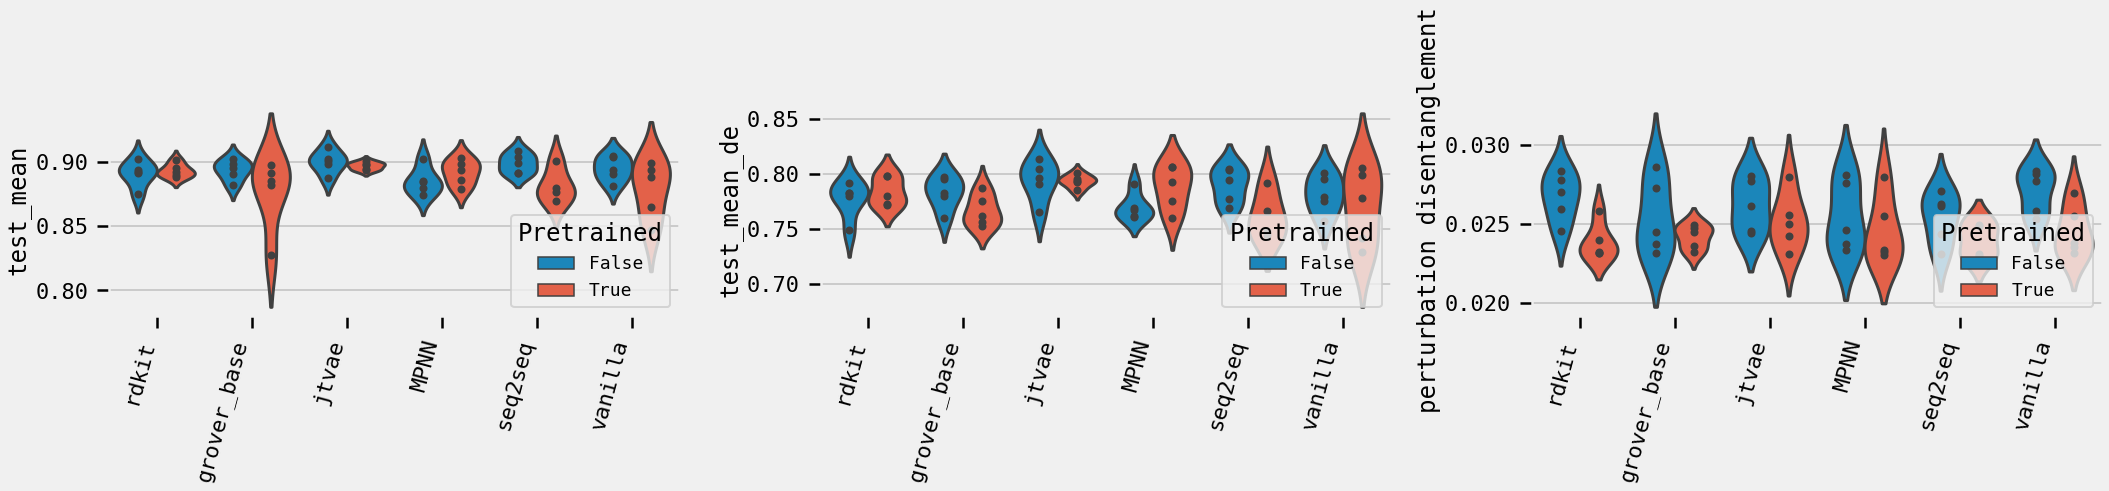

In [50]:
# All genes, DE genes, disentanglement
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(["result.test_mean", "result.test_mean_de", "result.perturbation disentanglement"]):
    sns.violinplot(
        data=best, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    # ax[i].set_ylim([0.75, 1.01])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)
plt.tight_layout()


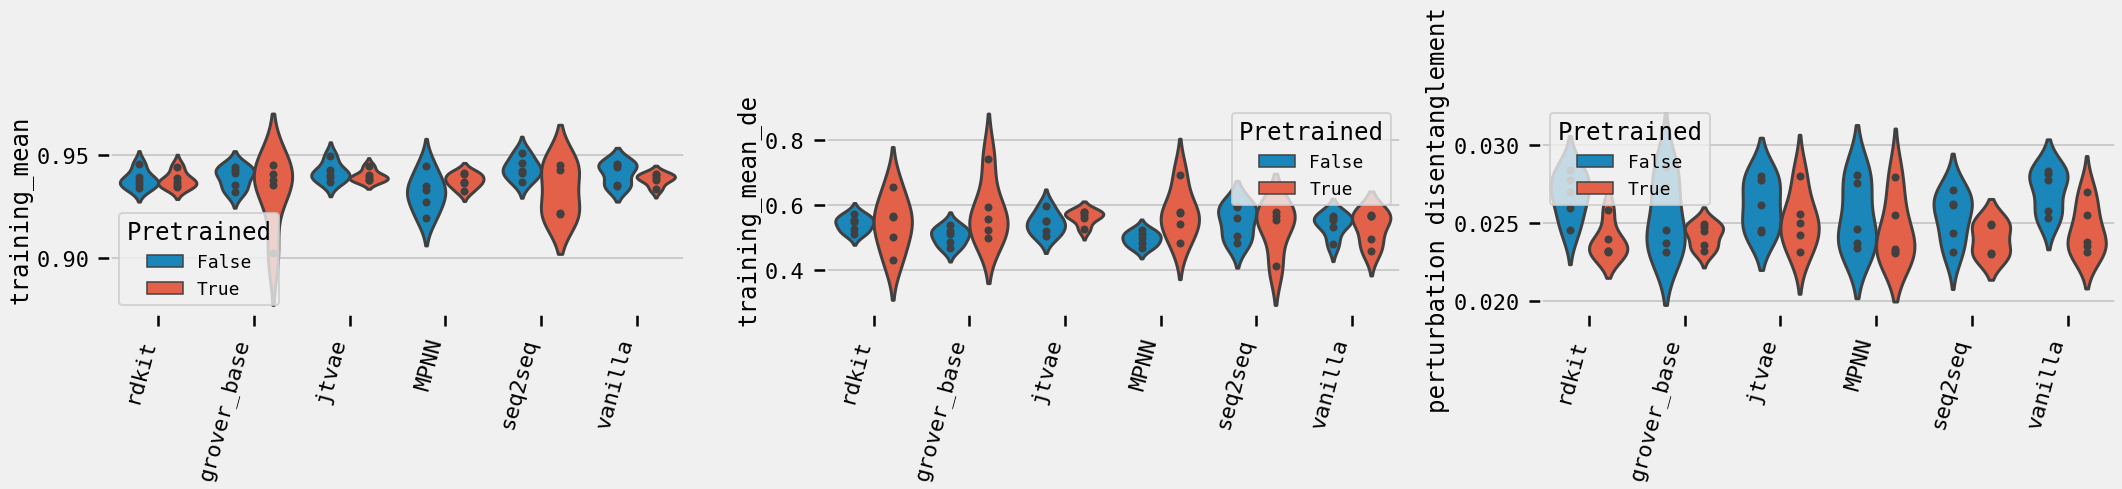

In [51]:
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(["result.training_mean", "result.training_mean_de", "result.perturbation disentanglement"]):
    sns.violinplot(
        data=best, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='best', fontsize=18, title_fontsize=24)
plt.tight_layout()

## Take a deeper look in the `.config` of the best performing models

In [52]:
best[["config." + col for col in sweeped_params] +
     ["result.perturbation disentanglement", "result.test_mean", "result.test_mean_de"]]

,config.model.hparams.dosers_lr,config.model.hparams.dosers_wd,config.model.hparams.autoencoder_lr,config.model.hparams.autoencoder_wd,config.model.hparams.adversary_width,config.model.hparams.adversary_depth,config.model.hparams.adversary_lr,config.model.hparams.adversary_wd,config.model.hparams.adversary_steps,config.model.hparams.reg_adversary,config.model.hparams.penalty_adversary,config.model.hparams.batch_size,config.model.hparams.step_size_lr,result.perturbation disentanglement,result.test_mean,result.test_mean_de
0,0.000561,1.329292e-07,0.000561,1.329292e-07,128,2,0.000364,7.459343e-07,3,15.355287,2.368864,64,50,0.023957,0.895001,0.798590
8,0.001593,6.358359e-07,0.001593,6.358359e-07,128,3,0.001208,1.012920e-05,3,30.271829,3.991306,128,50,0.023137,0.901240,0.797712
3,0.001575,6.251374e-07,0.001575,6.251374e-07,128,4,0.001193,9.846739e-06,3,30.049874,3.968793,64,50,0.025819,0.889893,0.772694
4,0.000205,2.938028e-08,0.000205,2.938028e-08,128,3,0.000114,6.026889e-08,3,7.979119,1.432249,128,50,0.023219,0.891926,0.780230
5,0.000205,2.937538e-08,0.000205,2.937538e-08,128,2,0.000114,6.025216e-08,2,7.978542,1.432170,128,50,0.023172,0.887906,0.771454
18,0.001593,6.358359e-07,0.001593,6.358359e-07,128,3,0.001208,1.012920e-05,3,30.271829,3.991306,128,50,0.025924,0.902403,0.791730
15,0.000205,2.937538e-08,0.000205,2.937538e-08,128,2,0.000114,6.025216e-08,2,7.978542,1.432170,128,50,0.028360,0.891505,0.779493
13,0.001575,6.251374e-07,0.001575,6.251374e-07,128,4,0.001193,9.846739e-06,3,30.049874,3.968793,64,50,0.024542,0.893363,0.782344
10,0.000561,1.329292e-07,0.000561,1.329292e-07,128,2,0.000364,7.459343e-07,3,15.355287,2.368864,64,50,0.026978,0.874979,0.748473
16,0.000131,1.493657e-08,0.000131,1.493657e-08,128,4,0.000068,1.951722e-08,3,5.950295,1.143098,64,50,0.027739,0.891951,0.782826
